In [1]:
import random
from collections import deque, namedtuple
import numpy as np

Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward', 'done', 'priority'))

class ReplayMemory:
    def __init__(self, capacity=50_000):
        self.capacity = capacity
        self.memory = deque(maxlen=capacity)
        self.alpha = 0.6  # 控制优先级效果强度

    def push(self, state, action, next_state, reward, done, priority=None):
        if priority is None:
            priority = 1.0  # 默认初始优先级
        self.memory.append(Transition(state, action, next_state, reward, done, priority))

    def sample(self, batch_size):
        # 按 priority^alpha 归一化为概率分布
        priorities = np.array([t.priority for t in self.memory], dtype=np.float32)
        probs = priorities ** self.alpha
        probs /= probs.sum()

        indices = np.random.choice(len(self.memory), batch_size, p=probs)
        samples = [self.memory[i] for i in indices]
        return samples, indices, probs[indices]

    def update_priorities(self, indices, new_priorities):
        for idx, p in zip(indices, new_priorities):
            self.memory[idx] = self.memory[idx]._replace(priority=float(p))

    def __len__(self):
        return len(self.memory)


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class DQN(nn.Module):
    def __init__(self, state_shape, n_actions):
        super(DQN, self).__init__()
        c, h, w = state_shape  # e.g., 4, 80, 80
        self.conv = nn.Sequential(
            nn.Conv2d(4, 32, 8, 4, padding=2), nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, padding=1), nn.ReLU(),
            nn.Conv2d(64, 64, 3, 1, padding=1), nn.ReLU()
        )

        self.attn = nn.MultiheadAttention(embed_dim=64, num_heads=8, batch_first=True)

        self.fc = nn.Sequential(
            nn.Linear(64, 512), nn.ReLU(),
            nn.Linear(512, n_actions)
        )

    def forward(self, x):
        x = self.conv(x)                     # [B, 64, 10, 10]
        B, C, H, W = x.shape
        x = x.view(B, C, H*W).permute(0, 2, 1)  # [B, 100, 64]
        x, _ = self.attn(x, x, x)              # [B, 25, 64]
        x = x.mean(dim=1)                      # [B, 64]
        x = self.fc(x)                         # [B, n_actions]
        return x

    

# net = DQN((80, 80, 4), 2)
# test_data = torch.randn(1, 4, 80, 80)
# print(net(test_data).shape)

In [3]:
class Agent:

    def __init__(self, state_shape, n_actions, gamma=0.99, capacity=10_000, batch_size=32, target_update=1000, pth_path=None):
        # self.device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu') # Mac OS
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # Linux
        self.state_shape = state_shape
        self.n_actions = n_actions
        self.gamma = gamma
        self.batch_size = batch_size
        self.memory = ReplayMemory(capacity)
        self.model = DQN(state_shape, n_actions).to(self.device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=1e-5)

        if pth_path is not None:
            self.model.load_state_dict(torch.load(pth_path, map_location=self.device))
            print('load model from', pth_path)

        self.target_net = DQN(state_shape, n_actions).to(self.device)
        self.target_net.load_state_dict(self.model.state_dict())
        self.target_update = target_update
        self.learn_step_counter = 0
        self.loss_item = None

    def _replay(self):
        # if len(self.memory) < self.batch_size:
        if len(self.memory) < 20_000:
            return
        # list of transition
        batch, indices, sample_probs = self.memory.sample(self.batch_size)

        # # Transition, column: len(tuple) == batch_size
        # batch = Transition(*zip(*batch))
        # # batch to tensor
        # # batch = torch.cat([torch.as_tensor(t, device=self.device).unsqueeze(0) for t in batch]).float()
        # batch = [torch.as_tensor(t, device=self.device).float() for t in batch]
        # state, action, next_state, reward, done = batch
        # action = action.unsqueeze(1)
        # # 把action改成int64
        # action = action.to(torch.int64)
        # reward = reward.unsqueeze(1)
        # done = done.unsqueeze(1)

        # 假设 batch 是 Transition(*zip(*samples))
        batch = Transition(*zip(*batch))
        states = np.stack(batch.state).astype(np.float32)    # shape (B, 4, 80, 80)
        next_states = np.stack(batch.next_state).astype(np.float32)
        actions = np.array(batch.action).astype(np.int64).reshape(-1,1)  # (B,1)
        rewards = np.array(batch.reward).astype(np.float32).reshape(-1,1)
        dones   = np.array(batch.done).astype(np.float32).reshape(-1,1)

        state = torch.from_numpy(states).to(self.device)
        next_state = torch.from_numpy(next_states).to(self.device)
        action = torch.from_numpy(actions).to(self.device)
        reward = torch.from_numpy(rewards).to(self.device)
        done = torch.from_numpy(dones).to(self.device)
        # print(f'state: {state.shape}, action: {action.shape}, next_state: {next_state.shape}, reward: {reward.shape}, done: {done.shape}')

        #state shape: (batch_size, 4, 80, 80)
        #action shape: (batch_size, 1)
        #next_state shape: (batch_size, 4, 80, 80)
        #reward shape: (batch_size, 1)
        #done shape: (batch_size, 1)
        self.model.eval()
        # pred
        state_action_values = self.model(state).gather(dim=1, index=action) # self.model 输出是 [batch, action_space]，gather(dim=1, index=action) 取出 action 对应的 Q 值
        next_state_values = self.target_net(next_state).max(dim=1)[0].detach().unsqueeze(1)
        expected_state_action_values = (next_state_values * self.gamma * (1 - done)) + reward

        # TD-err 作为优先级依据
        td_err = torch.abs(state_action_values - expected_state_action_values).detach().cpu().numpy()
        self.memory.update_priorities(indices, td_err + 1e-5)

         # 定期更新目标网络
        self.learn_step_counter += 1
        if self.learn_step_counter % self.target_update == 0:
            self.target_net.load_state_dict(self.model.state_dict())

        # loss
        self.model.train()
        loss = F.smooth_l1_loss(state_action_values, expected_state_action_values)

        # optimize
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.loss_item = loss.item()

    def update_q_function(self):
        self._replay()

    def memorize(self, state, action, next_state, reward, done):
        self.memory.push(state, action, next_state, reward, done)

    def choose_action(self, state, episode):
        # eps = 0.5 * 1 / (1+episode)
        eps = max(0.05, 0.5 * (0.996 ** episode))
        eps = 0 # 不探索
        if random.random() < eps:
            # explore
            action = random.randrange(self.n_actions) # shape: (1,)
            # action = torch.tensor([action]).unsqueeze(0) # shape: (1,1)
        else:
            # exploit
            state = state.astype(np.float32)
            state = torch.from_numpy(state).to(self.device).unsqueeze(0) # shape: (1, 4, 80, 80)
            self.model.eval()
            with torch.no_grad():
                action = self.model(state).argmax() # shape: (1,)
                # action = action.view(1, 1) # shape: (1,1)
                action = action.item() # shape: ()
        action = np.array([action])[None, :] # shape: (1,1)
        return action

        

In [4]:
def load_checkpoint(agent, path='checkpoint.pth'):
    import torch, pickle, os

    # 1. 加载主 checkpoint
    checkpoint = torch.load(path, map_location=agent.device)
    agent.model.load_state_dict(checkpoint['model_state_dict'])
    agent.target_net.load_state_dict(checkpoint['target_state_dict'])
    agent.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    # 2. 加载 epsilon 等参数
    if 'epsilon' in checkpoint and checkpoint['epsilon'] is not None:
        agent.epsilon = checkpoint['epsilon']
    agent.gamma = checkpoint.get('gamma', agent.gamma)
    agent.batch_size = checkpoint.get('batch_size', agent.batch_size)

    # 3. 尝试加载 ReplayMemory
    mem_path = path.replace('.pth', '_memory.pkl')
    if os.path.exists(mem_path):
        with open(mem_path, 'rb') as f:
            agent.memory = pickle.load(f)
        print(f"[√] Replay memory loaded ({len(agent.memory)} transitions)")
    else:
        print("[!] No replay memory file found, starting with empty buffer.")

    print(f"[√] Model, optimizer, and target net loaded from {path}")
    return checkpoint.get('episode', 0)  # 返回上次训练到的轮次


### agent 与 env 交互

In [5]:
import gym
import gym_chrome_dino
from gym_chrome_dino.utils.wrappers import make_dino
env = gym.make('ChromeDino-v0', accelerate=True)
# env = gym.make('ChromeDinoNoBrowser-v0', accelerate=True)
env = make_dino(env, timer=False, frame_stack=True, width=80, height=80)
n_actions = env.action_space.n
state_shape = env.observation_space.shape

score_history = []
loss_history = []
max_episode = 3_000
# agent = Agent(state_shape, n_actions, capacity=10_000, batch_size=64, pth_path='./dino_dqn_122.pth')
# agent = Agent(state_shape, n_actions, capacity=50_000, batch_size=64, target_update=500, pth_path='dino4_accelerate_dqn_100.pth')
# agent = Agent(state_shape, n_actions, capacity=50_000, batch_size=64, target_update=500, pth_path='dino6_accelerate_dqn_200_1.pth')
agent = Agent(state_shape, n_actions, capacity=50_000, batch_size=64, target_update=500)


episode = load_checkpoint(agent, path='dino_accelerate_dqn3.pth')
frame_cnt = 0
for episode in range(max_episode):
    state = env.reset()
    state = np.array(state._frames)[:, :, :, 0] / 255.0 # 归一化到 [0,1] 之间
    done = False
    while not done:
        frame_cnt += 1
        action = agent.choose_action(state, episode)

        next_state, reward, done, info = env.step(action.item())
        next_state = np.array(next_state._frames)[:, :, :, 0] / 255.0 # shape: (4, 80, 80)

        # reward = torch.tensor([reward], device=agent.device).float()
        # done = torch.tensor([done], device=agent.device).float()
        # reward = reward.item()
        # done = done.item()
        
        agent.memorize(state, action, next_state, reward, done)
        agent.update_q_function()
        state = next_state
    
    score_history.append(env.unwrapped.game.get_score())
    loss_history.append(agent.loss_item)
    if episode % 10 == 0:
        # eps = 0.5 * 1 / (1+episode)
        eps = max(0.05, 0.5 * (0.996 ** episode))
        eps = 0
        print(f"episode: {episode}, max score from 10 games: {max(score_history[-10:])}, eps: {eps:.3f}, frame_cnt: {frame_cnt}")

    if episode % 100 == 0 and episode != 0:
        torch.save(agent.model.state_dict(),f'./dino6_accelerate_dqn_{episode}.pth')

    if episode % 100 == 0 and episode > 0:
        env.close()
        env = gym.make('ChromeDino-v0', accelerate=True)
        env = make_dino(env, timer=False, frame_stack=True, width=80, height=80)
        # env.reset()

    
        

[√] Replay memory loaded (50000 transitions)
[√] Model, optimizer, and target net loaded from dino_accelerate_dqn3.pth


/tmp/ipykernel_158777/611914438.py:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.memory[idx] = self.memory[idx]._replace(priority=float(p))


episode: 0, max score from 10 games: 51, eps: 0.000, frame_cnt: 27
episode: 10, max score from 10 games: 653, eps: 0.000, frame_cnt: 10881
episode: 20, max score from 10 games: 485, eps: 0.000, frame_cnt: 18678
episode: 30, max score from 10 games: 490, eps: 0.000, frame_cnt: 26119
episode: 40, max score from 10 games: 576, eps: 0.000, frame_cnt: 36393
episode: 50, max score from 10 games: 640, eps: 0.000, frame_cnt: 44452
episode: 60, max score from 10 games: 660, eps: 0.000, frame_cnt: 54063
episode: 70, max score from 10 games: 640, eps: 0.000, frame_cnt: 67035
episode: 80, max score from 10 games: 534, eps: 0.000, frame_cnt: 73267
episode: 90, max score from 10 games: 684, eps: 0.000, frame_cnt: 80724
episode: 100, max score from 10 games: 523, eps: 0.000, frame_cnt: 88898
episode: 110, max score from 10 games: 624, eps: 0.000, frame_cnt: 99031
episode: 120, max score from 10 games: 607, eps: 0.000, frame_cnt: 106061
episode: 130, max score from 10 games: 985, eps: 0.000, frame_cnt

NoSuchWindowException: Message: no such window: target window already closed
from unknown error: web view not found
  (Session info: chrome=141.0.7390.65)


In [ ]:
# 保存模型权重
torch.save(agent.model.state_dict(),f'./dino6_accelerate_dqn_{episode}.pth')
print(f'saved model to ./dino_accelerate_dqn_{episode}.pth')

# 载入模型权重
# agent.model.load_state_dict(torch.load(f'./dino_dqn_{episode}.pth'))

saved model to ./dino_accelerate_dqn_377.pth


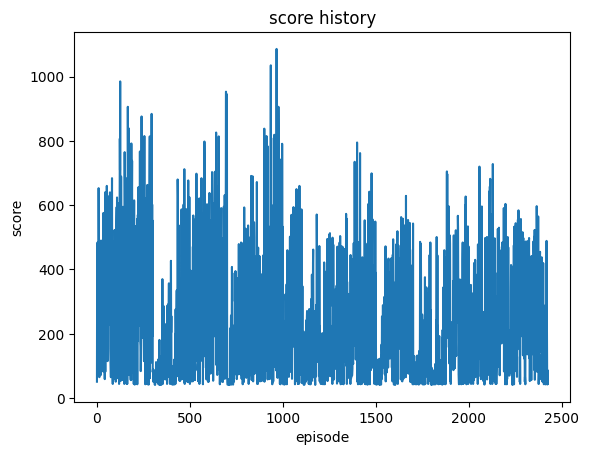

In [6]:
import matplotlib.pyplot as plt
plt.plot(score_history)
plt.xlabel('episode')
plt.ylabel('score')
plt.title('score history')
plt.show()

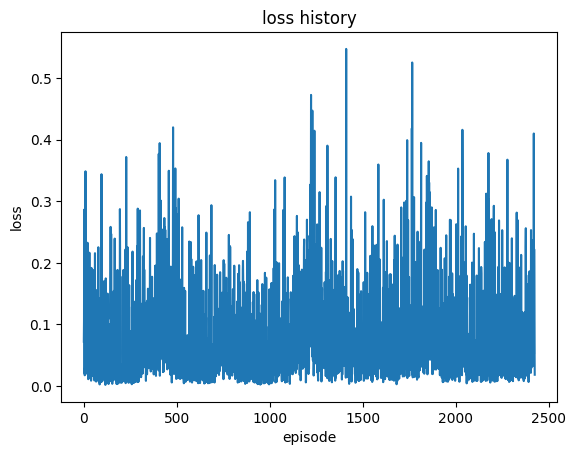

In [7]:
plt.plot(loss_history)
plt.xlabel('episode')
plt.ylabel('loss')
plt.title('loss history')
plt.show()

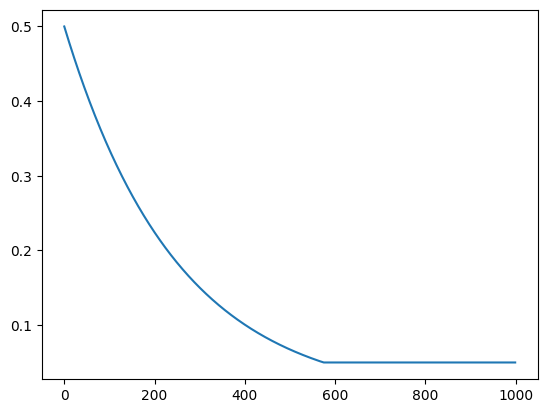

In [8]:
import matplotlib.pyplot as plt
eps_list = [max(0.05, 0.5 * (0.996 ** i)) for i in range(1000)]
plt.plot(eps_list)
plt.show()

In [9]:
import torch
import pickle

def save_checkpoint(agent, episode, path='checkpoint.pth'):
    # 确保 ReplayMemory 可以保存
    with open(path.replace('.pth', '_memory.pkl'), 'wb') as f:
        pickle.dump(agent.memory, f)
        print(f"[√] Replay memory saved ({len(agent.memory)} transitions)")

    checkpoint = {
        'episode': episode,
        'model_state_dict': agent.model.state_dict(),
        'target_state_dict': agent.target_net.state_dict(),
        'optimizer_state_dict': agent.optimizer.state_dict(),
        'epsilon': getattr(agent, 'epsilon', None),  # 如果你在 Agent 里维护 epsilon
        'gamma': agent.gamma,
        'batch_size': agent.batch_size,
    }
    torch.save(checkpoint, path)
    print(f"[√] Checkpoint saved at {path}")

save_checkpoint(agent, episode, path='dino_accelerate_dqn4.pth')

[√] Replay memory saved (50000 transitions)
[√] Checkpoint saved at dino_accelerate_dqn4.pth


# inference

In [4]:
import gym
import gym_chrome_dino
from gym_chrome_dino.utils.wrappers import make_dino
env = gym.make('ChromeDino-v0', accelerate=True)
# env = gym.make('ChromeDinoNoBrowser-v0', accelerate=True)
env = make_dino(env, timer=False, frame_stack=True, width=80, height=80)
n_actions = env.action_space.n
state_shape = env.observation_space.shape

max_episode = 10
# agent = Agent(state_shape, n_actions, capacity=10_000, batch_size=64, pth_path='./dino_dqn_122.pth')
# test_agent = Agent(state_shape, n_actions, capacity=20_000, batch_size=64, target_update=500, pth_path='./dino3_accelerate_dqn_300.pth')
test_agent = Agent(state_shape, n_actions, capacity=20_000, batch_size=64, target_update=500, pth_path='./dino6_accelerate_dqn_1000.pth')

episode = 0
for episode in range(max_episode):
    state = env.reset()
    state = np.array(state._frames)[:, :, :, 0] / 255.0
    done = False
    while not done:
        state = state.astype(np.float32)
        state = torch.from_numpy(state).to(test_agent.device).unsqueeze(0) # shape: (1, 4, 80, 80)
        test_agent.model.eval()
        with torch.no_grad():
            action = test_agent.model(state).argmax() # shape: (1,)
            action = action.item() # shape: ()

        next_state, reward, done, info = env.step(action)
        next_state = np.array(next_state._frames)[:, :, :, 0] / 255.0 # shape: (4, 80, 80)

        state = next_state


    print(f"episode: {episode}, score: {env.unwrapped.game.get_score()}")
    
        

load model from ./dino6_accelerate_dqn_1000.pth
episode: 0, score: 51
episode: 1, score: 162
episode: 2, score: 125
episode: 3, score: 296
episode: 4, score: 945
episode: 5, score: 936
episode: 6, score: 503
episode: 7, score: 183
episode: 8, score: 624
episode: 9, score: 1172
